## 2. Problema de Múltiples Anotaciones

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

from scipy import spatial

from sklearn.neighbors import KNeighborsClassifier

<a id="segundo"></a>

El aprendizaje supervisado visto en clases da cuenta que existe una única posible etiqueta $z$ (*ground truth*) asociada a un dato $x$ para poder aprender de los datos. Sin embargo, la definición del *ground truth* en algunos casos puede resultar bastante difícil de definir o bastante costoso, por ejemplo en problemas médicos donde se deben realizar invasivos exámenes para conocer la "verdad absoluta". Como alternativa se pueden recolectar múltiples anotaciones desde personas inexpertas en el área para poder estimar el *ground truth*. 

<img src="http://www.irishenvironment.com/wp-content/uploads/2013/11/crowdsourcing.jpg" title="Title text" width="40%" />

En esta actividad se trabajará en el caso en que contamos con múltiples anotaciones por cada dato de entrada $x_i$ dadas por personas inexpertas a través de Amazon Mechanical Turk (__[AMT](https://www.mturk.com/)__), es decir, $y^{(1)}, y^{(2)} \ldots y^{(T_i)}$. El problema de predicción trabajado será el mismo de la actividad anterior, el análisis de sentimiento de un extracto de texto en Rotten Tomatoes. Los datos trabajados [[8]](#refs) pueden ser descargados de la página del autor.
```
wget http://fprodrigues.com//mturk-datasets.tar.gz
```

De esta manera trabajaremos con el archivo *mturk_answers.csv* en la carpeta *sentiment polarity* que se puede cargar con pandas. En este archivo se tendrán múltiples filas/registros por cada dato de entrenamiento, cada uno representando la etiqueta que entregó una persona (*worker*) a ese dato, los detalles de columnas son:
* *WorkerId*: identificador de la persona que etiquetó/anotó el dato
* *Input.id*: identificador del dato a etiquetar/anotar
* *Input.original_sentence*: texto original del dato
* *Input.stemmed_sent*: texto pre-procesado
* *Input.true_sent*: sentimiento real (*ground truth*) del dato
* *Answer.sent*:   etiqueta/anotación que entregó la persona

```python
import pandas as pd
df = pd.read_csv("./sentiment_polarity/mturk_answers.csv") 
```

> El objetivo de la actividad será el de obtener un modelo predictor del *ground truth* sin entrenar directamente con esto, sino que utilizar las múltiples anotaciones de las personas

### Importante
* Deberá crear un conjunto aleatorio de pruebas que solo contenga los textos y el sentimiento *ground truth* (sin repeticiones)
* Los valores de *ground truth* están **solo para evaluar**, no puede utilizarlos para entrenar o tomar decisiones en su modelo.
* La métrica de evaluación será el *accuracy score*
```python
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
```

#### Sugerencias
Para representar los textos, a diferencia de lo visto en la sección 1, se puede utilizar lo que son la representación vectorial de palabras (*word vectors*), a través de modelos especializados entrenados para aprender una representación en que palabras similares estén cercanas en el espacio vectorial. Puede utilizar los vectores livianos de __[GLOVE](https://nlp.stanford.edu/projects/glove/)__ en su versión entradas en textos de Wikipedia con 6 billones de palabras/tokens.
```python
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
...
embeddings_index.get(word)
```
> Para descargar GLOVE
```
wget http://nlp.stanford.edu/data/glove.6B.zip
```

## Desarrollo

Para el desarrollo de esta actividad procederemos a realizar un paralelismo a lo solicitado en la sección uno de este informe.

In [4]:
names = ['Worker', 'idData', 'rawData', 'stemData', 'GTruth', 'Answer']

### Datos

En primera instancia importaremos los datos, luego los separaremos y haremos algunos resumenes de las informaciones que extraigasemos.

In [6]:
df = pd.read_csv("./mturk-datasets/sentiment_polarity/mturk_answers.csv", names=names, header=0) 
df.head()

,Worker,idData,rawData,stemData,GTruth,Answer
0,A2HD5XMM48KKJW,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,pos,pos
1,A2HD5XMM48KKJW,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,neg,neg
2,A2HD5XMM48KKJW,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,neg,pos
3,A2HD5XMM48KKJW,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,pos,neg
4,A2HD5XMM48KKJW,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,pos,pos


En lo siguiente, separaremos los datos para lograr saber cuantas anotadoras existen, cuantas instancias existen, cual es el promedio de anotadoras por dato y el promedio de datos etiquetados por anotadora. De la misma forma, mostraremos datos respecto a cuantos ejemplos por cada clase existen, longitud de texto y otros.

In [202]:
anotadoras = df.groupby(['Worker']).size().reset_index(name='count')
instancias = df.groupby(['idData', 'GTruth']).size().reset_index(name='count')
instancias.head()

,idData,GTruth,count
0,2,pos,6
1,3,pos,6
2,4,pos,5
3,9,pos,6
4,11,pos,4


In [56]:
print ('Cantidad de anotadoras:', len(anotadoras))
print ('Cantidad de instancias:', len(instancias))
print ('Promedio de instancias por anotadora :', round(anotadoras['count'].mean(), 2))
print ('Máximo de instancias por anotadora :', round(anotadoras['count'].max(), 2))
print ('Mínimo de instancias por anotadora :', round(anotadoras['count'].min(), 2))

print ('Promedio de anotadoras por instancias :', round(instancias['count'].mean(), 2))
print ('Máximo de anotadoras por instancias :', round(instancias['count'].max(), 2))
print ('Mínimo de anotadoras por instancias :', round(instancias['count'].min(), 2))

Cantidad de anotadoras: 203
Cantidad de instancias: 4999
Promedio de instancias por anotadora : 136.68
Máximo de instancias por anotadora : 3993
Mínimo de instancias por anotadora : 5
Promedio de anotadoras por instancias : 5.55
Máximo de anotadoras por instancias : 10
Mínimo de anotadoras por instancias : 4


In [80]:
textos = df.groupby(['idData', 'rawData','stemData']).size().reset_index(name='count')

In [90]:
textos['len(rawData)'] = textos['rawData'].str.split().str.len()
textos['len(stemData)'] = textos['stemData'].str.split().str.len()

In [93]:
print ('Textos originales')
print ('Promedio de palabras:', round(textos['len(rawData)'].mean(), 2))
print ('Máximo de palabras:', textos['len(rawData)'].max())
print ('Mínimo de palabras:', textos['len(rawData)'].min())
print ('Textos pre-procesados')
print ('Promedio de palabras:', round(textos['len(stemData)'].mean(), 2))
print ('Máximo de palabras:', textos['len(stemData)'].max())
print ('Mínimo de palabras:', textos['len(stemData)'].min())

Textos originales
Promedio de palabras: 20.95
Máximo de palabras: 57
Mínimo de palabras: 2
Textos pre-procesados
Promedio de palabras: 10.29
Máximo de palabras: 29
Mínimo de palabras: 1


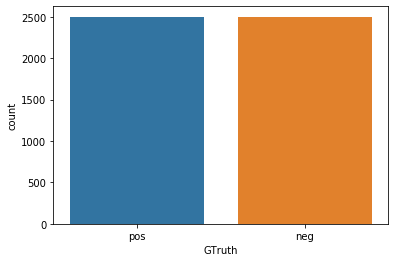

In [305]:
sns.countplot('GTruth',data = instancias)

### Inferencia del ground truth

Para esta subsección realizaremos la actividad principal del enunciado donde se pide realizar el entrenamiento mediante el uso exclusivo de las respuestas entregadas por las anotadoras sin utilizar el ground truth real, pudiendo solo utilizar este último para realizar una evaluación comparativa con la realidad.

Concretamente nosotros postulamos dos métodos, el clásico y siempre confiable igualitarismo sobre las anotadoras, donde podemos confiar en ellas por igual independiente de cualquier variable. Llamaremos a esto *majority voting*, mientras que como segunda opción, le daremos un nivel de confianza (*worker quality*) a las anotadoras, en base a su rendimiento grupal.


Para la codificación, utilizaremos **1** para positivos y **-1** para negativos.

In [207]:
# Codificando el ground truth
groundtruth = instancias[['GTruth']].where(instancias['GTruth'] == 'pos', -1).where(instancias['GTruth'] == 'neg', 1)
groundtruth['idData'] = instancias[['idData']]
groundtruth = groundtruth.set_index('idData')
groundtruth.head()

,GTruth
idData,
2,1
3,1
4,1
9,1
11,1


#### Majority Voting

Para este método contaremos con todas las respuestas de las anotadoras y presentaremos los resultados con mayor ocurrencia por instancia, donde aquellos que se encuentren empatados serán resueltos mediante una elección aleatorea.

In [198]:
def majority_voting(df):
    # Reduciendo Dataframe
    respuestas = df.groupby(['idData', 'Worker','Answer']).size().reset_index(name='count')
    # Codificando respuestas
    respuestas['CodAnswer'] = respuestas[['Answer']].where(respuestas['Answer'] == 'pos', -1).where(respuestas['Answer'] == 'neg', 1)
    # Agregando respuestas
    MV = respuestas.groupby(by='idData').agg({'CodAnswer':'sum'})
    # Resolucion de empates y obtención de resultados
    MV = MV.mask(MV['CodAnswer'] > 0, 1).mask(MV['CodAnswer'] < 0, -1).mask(MV['CodAnswer'] == 0, np.random.choice([-1,1]))
    return MV

In [199]:
MV = majority_voting(df)
MV.head()

,CodAnswer
idData,
2,1
3,-1
4,1
9,1
11,1


#### Worker Quality 

Para este método utilizaremos un proceso iterativo hasta convergencia o bien, hasta algún criterio de parada. Lo que buscaremos será obtener un ground truth inicial y luego en base a ese mismo ground truth otorgarles a las anotadoras un valor de calidad relativo a su desempeño con respecto al resto. 

Para realizar esta tarea definiremos dos funciones, una que infiere el ground truth a través de la calidad, donde $W$ serán los *Workers* (anotadoras) de manera tal que para cada instancia exista un subconjunto $W_i$ con las anotadoras que hayan participado en la etiquetación de la instancia.

\begin{align}
    GT_{i} = sign(\sum_{w \in W_{i}} q_w A_{wi}) & \forall i
\end{align}

La segunda función será la de inferencia de calidad donde esta misma, esta dado por el *accuracy* (exactitud) de la anotadora en base al ground truth inferido. De forma que si un observador etiqueto 4 instancias y se equivocó en 1 su calidad se reduce a 0.75, considerando que $q \in \left[ 0,1\right]$. Todas las anotadoras parten con la misma calidad inicialmente.

Este método suena mucho más razonable y pertinente debido a que no poseemos mayor información de las anotadoras y sabemos que no todas las instancias han sido etiquetadas por la misma cantidad de *Workers*.

In [208]:
def quality_inference(df, gt):
    quality = dict()
    for row in df.values:
        idx, worker, _, _, answer = tuple(row)
        increment = np.array([1,0]) if gt.loc[idx][0] == answer else np.array([0,1])
        quality[worker] = quality.get(worker, np.array([0,0])) + increment
    for k,v in quality.items():
        quality[k] = v[0] / np.sum(v)
    return quality

In [197]:
def truth_inference(df, ql):
    inst = list()
    gt = list()
    aux = dict()
    for row in df.values:
        idx, worker, _, _, answer = tuple(row)
        aux[idx] = aux.get(idx, 0) + answer * ql[worker]
    for k,v in aux.items():
        inst.append(k)
        gt.append(v)
    outdf = pd.DataFrame({'idData': inst, 'CodAnswer': gt}).set_index('idData')
    outdf = outdf.mask(outdf['CodAnswer'] > 0, 1).mask(outdf['CodAnswer'] < 0, -1).mask(outdf['CodAnswer'] == 0, np.random.choice([-1,1]))
    return outdf

Debido a que partiremos de la premisa que todas las anotadoras cuentan con un mismo valor de calidad, utilizaremos el método **MV** para dar inicio a nuestro *loop*. Crearemos un parametro $C$ que cumplirá la función de criterio de parada para una cantidad de iteraciones. Al mismo tiempo, tenemos otro criterio de parada y es cuando durante 3 iteraciones seguidas, se encuentra un mismo valor para **truth_inference**, también procederemos a terminar las iteraciones.

In [298]:
def worker_quality(df, C=100):
    # Reduciendo Dataframe
    respuestas = df.groupby(['idData', 'Worker','Answer']).size().reset_index(name='count')
    # Codificando respuestas
    respuestas['CodAnswer'] = respuestas[['Answer']].where(respuestas['Answer'] == 'pos', -1).where(respuestas['Answer'] == 'neg', 1)
    # Inicializacion
    groundtruth = majority_voting(df)
    # Looping 
    stop = groundtruth[['CodAnswer']]
    convergence = 0
    for i in range(C):
        # Se obtiene la calidad inferida
        quality = quality_inference(respuestas, groundtruth)
        # Se obtiene el sentimiento inferido
        groundtruth = truth_inference(respuestas, quality)
        if (np.sum(stop['CodAnswer'] == groundtruth['CodAnswer']) == len(stop)):
            convergence += 1
        else:
            convergence = 0
        if (convergence == 3):
            break
        stop = groundtruth[['CodAnswer']]
    return groundtruth

In [300]:
WQ = worker_quality(df, 1000)
WQ.head()

,CodAnswer
idData,
2,1.0
3,-1.0
4,1.0
9,1.0
11,1.0


In [449]:
print ('Diferencia entre MV y WQ:', len(MV) - np.sum(WQ['CodAnswer'] == MV['CodAnswer']))
print ('Diferencia entre MV y GT:', len(MV) - np.sum(groundtruth['GTruth'] == MV['CodAnswer']))
print ('Diferencia entre WQ y GT:', len(groundtruth) - np.sum(groundtruth['GTruth'] == WQ['CodAnswer']))

Diferencia entre MV y WQ: 85
Diferencia entre MV y GT: 552
Diferencia entre WQ y GT: 527


Dentro del mismo tema, podemos pensar en propuestas para una continuación de esto, que puede ser, la detección de anotadoras maliciosas, una calidad sobre la clase particular (*más pensado para problemas multiclase*).

### Conjunto de testing y validación

En esta subsección, separaremos nuestros datos en 2 conjuntos, obteniendo así, un conjunto de entrenamiento y uno de testing, utilizaremos una proporción $80\%$ *training* y $20\%$ *testing* principalmente por la cantidad de datos que tenemos. Para poder realizar este proceso de forma rápida, en vez de utilizar las correspondientes etiquetas, utilizaremos el valor del identificador del dato, de forma tal que luego, podamos utilizar ese mismo dato para las distintas pruebas que realizaremos.

In [350]:
df_texts_raw = textos.rawData
df_texts_stem = textos.stemData
df_labels = textos.idData.values

df_train_textr, df_test_textr, labels_train_id, labels_test_id = train_test_split(df_texts_raw, df_labels, test_size=0.2, random_state=0)
df_train_texts, df_test_texts, labels_train_id, labels_test_id = train_test_split(df_texts_stem, df_labels, test_size=0.2, random_state=0)

In [346]:
df_train_textr.head()

2615    here's my advice , kev . start reading your sc...
1116             very well-written and very well-acted . 
4519    the movie resolutely avoids all the comic poss...
1478    because eight legged freaks is partly an homag...
156     hu and liu offer natural , matter-of-fact perf...
Name: rawData, dtype: object

In [347]:
df_train_texts.head()

2615       here advic kev start read script sign dot line
1116                                          written act
4519    movi resolut avoid comic possibl situat becom ...
1478    eight leg freak partli homag tarantula low bud...
156     hu liu offer natur matter fact perform glint s...
Name: stemData, dtype: object

In [348]:
print (df_train_text.shape)
print (df_test_text.shape)

(3999,)
(1000,)


Ahora realizaremos el mismo proceso pero para obtener un conjunto de validación.

In [351]:
df_train_textr, df_val_textr, labels_train_ids, labels_val_ids = train_test_split(df_train_textr, labels_train_id, test_size=0.2, random_state=0)
df_train_texts, df_val_texts, labels_train_ids, labels_val_ids = train_test_split(df_train_texts, labels_train_id, test_size=0.2, random_state=0)

In [340]:
def get_labels(labels_ids, labels_values):
    return np.array([labels_values.loc[idx][0] for idx in labels_ids])

In [354]:
Glabels_test_id = get_labels(labels_test_id, groundtruth)
Mlabels_train_id = get_labels(labels_train_ids, MV)
Wlabels_train_id = get_labels(labels_train_ids, WQ)
Mlabels_val_id = get_labels(labels_val_ids, MV)
Wlabels_val_id = get_labels(labels_val_ids, WQ)

In [355]:
print (Glabels_test_id.shape)
print (Mlabels_train_id.shape)
print (Wlabels_train_id.shape)
print (Mlabels_val_id.shape)
print (Wlabels_val_id.shape)

(1000,)
(3199,)
(3199,)
(800,)
(800,)


### Vectores de palabras

En base a la sugerencia del enunciado, utilizaremos **GloVe**.

In [240]:
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove/glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE, encoding='utf8') as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

Aquí adelante, presentamos un breve código donde al variar la cantidad de palabras visualizadas, podremos notar como se reparten las palabras en el espacio.

In [266]:
tsne = TSNE(n_components=2, random_state=0)
words = list(embeddings_index.keys())
vectors = [embeddings_index[word] for word in words]

In [279]:
Y = tsne.fit_transform(vectors[:100])

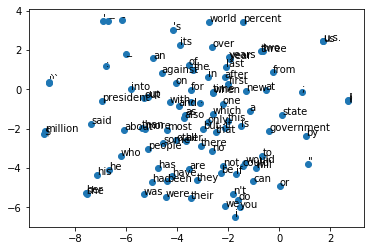

In [280]:
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

Estamos al tanto de que existen varios métodos para utilizar esta representación, sin embargo en honor al tiempo, eligiremos utilizar el promedio de las representaciones de las palabras dentro de una frase de manera que si $g_w$ es el vector representado por *glove* para la palabra $w$, entonces nuestra frase $f$ será representada por:

\begin{align}
\frac{\sum_{w \in f} g_w}{\sum_{w \in f} 1}
\end{align}

In [410]:
def TextToVector(text, representation):
    words = text.split()
    wv = np.zeros(EMBEDDING_DIM)
    for word in words:
        wv += representation.get(word, 0)
    return wv / len(words)

**A tomar en consideración, que como estamos utilizando los textos pre-procesados, existirán algunas palabras que no serán añadidas a esta represetación, como también las palabras que se encuentren mal escritan, por más que puedan ser muy relevantes, estas no afectarán al modelo que hemos planteado.**

In [250]:
# Ejemplo de lo anterior
df_train_text[0]

'gorgeous elabor continu lord ring trilogi huge column word adequ describ co writer director peter jackson expand vision j r r tolkien middl earth'

In [253]:
embeddings_index['trilogi']

KeyError: 'trilogi'

Por esta razón, para subsanar estos casos, se suma $0$ si la palabra no es encontraba en la representación.

Ahora que tenemos nuestra función para representar lo que sería **AWE** (*average word embedding*) transformaremos nuestros datos y crearemos un dataframe simil al original pero codificado.

In [411]:
def GloVe(Series):
    aux = list()
    for sentence in Series.values:
        aux.append(TextToVector(sentence, embeddings_index))
    return pd.Series(aux)

In [412]:
train_glove_raw = GloVe(df_train_textr)
train_glove_stem = GloVe(df_train_texts)

val_glove_raw = GloVe(df_val_textr)
val_glove_stem = GloVe(df_val_texts)

test_glove_raw = GloVe(df_test_textr)
test_glove_stem = GloVe(df_test_texts)

In [413]:
train_glove_raw = np.array(train_glove_raw.to_list())
train_glove_stem = np.array(train_glove_stem.to_list())

val_glove_raw = np.array(val_glove_raw.to_list())
val_glove_stem = np.array(val_glove_stem.to_list())

test_glove_raw = np.array(test_glove_raw.to_list())
test_glove_stem = np.array(test_glove_stem.to_list())

### Prueba de modelos

En primera instancia utilizaremos una regresion lineal como se realiza en la primera sección de este informe, también probaremos el algoritmo de similaridad *KNN*. En honor al tiempo se deja planteada la opción de utilizar estructuras más complejas, como modelos de estructuras jerarquicas con atención para mayor comprensión de texto. Sin embargo, como estas estructuras mencionadas se basan en modelos con *GRU* en distintos niveles (*caracteres, palabras, sentencias y/o documentos*) tienen tiempos de entrenamiento relativamente altos por epoca **~45m** por época, al mismo tiempo, la cantidad de datos puede no ser lo suficientemente relevante como para proporcionar la suficiente información.

In [372]:
# Regresion: rawData - Majority Voting [RRM]
regresion1 = LogisticRegression(solver='lbfgs')
regresion1.set_params(C=10**-3)
regresion1.fit(train_glove_raw, Mlabels_train_id)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [374]:
RRM_train_acc = regresion1.score(train_glove_raw, Mlabels_train_id)
RRM_valid_acc = regresion1.score(val_glove_raw, Mlabels_val_id)
print ('Accuracy Regresion RRM entrenamiento:', RRM_train_acc)
print ('Accuracy Regresion RRM validacion:', RRM_valid_acc)

Accuracy Regresion RRM entrenamiento: 0.6214442013129103
Accuracy Regresion RRM validacion: 0.6125


In [375]:
# Regresion: rawData - Worker Quality [RRW]
regresion2 = LogisticRegression(solver='lbfgs')
regresion2.set_params(C=10**-3)
regresion2.fit(train_glove_raw, Wlabels_train_id)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [376]:
RRW_train_acc = regresion2.score(train_glove_raw, Wlabels_train_id)
RRW_valid_acc = regresion2.score(val_glove_raw, Wlabels_val_id)
print ('Accuracy Regresion RRW entrenamiento:', RRW_train_acc)
print ('Accuracy Regresion RRW validacion:', RRW_valid_acc)

Accuracy Regresion RRW entrenamiento: 0.5342294467020944
Accuracy Regresion RRW validacion: 0.5175


In [414]:
# Regresion: stemData - Majority Voting [RSM]
regresion3 = LogisticRegression(solver='lbfgs')
regresion3.set_params(C=10**-3)
regresion3.fit(train_glove_stem, Mlabels_train_id)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [418]:
RSM_train_acc = regresion3.score(train_glove_stem, Mlabels_train_id)
RSM_valid_acc = regresion3.score(val_glove_stem, Mlabels_val_id)
print ('Accuracy Regresion RSM entrenamiento:', RSM_train_acc)
print ('Accuracy Regresion RSM validacion:', RSM_valid_acc)

Accuracy Regresion RSM entrenamiento: 0.6273835573616755
Accuracy Regresion RSM validacion: 0.5925


In [417]:
# Regresion: stemData - Worker Quality [RSW]
regresion4 = LogisticRegression(solver='lbfgs')
regresion4.set_params(C=10**-3)
regresion4.fit(train_glove_stem, Wlabels_train_id)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [419]:
RSW_train_acc = regresion4.score(train_glove_stem, Wlabels_train_id)
RSW_valid_acc = regresion4.score(val_glove_stem, Wlabels_val_id)
print ('Accuracy Regresion RSW entrenamiento:', RSW_train_acc)
print ('Accuracy Regresion RSW validacion:', RSW_valid_acc)

Accuracy Regresion RSW entrenamiento: 0.5473585495467334
Accuracy Regresion RSW validacion: 0.5275


In [441]:
# KNeighbors: rawData - Majority Voting [KRM]
KNN1 = KNeighborsClassifier()
KNN1.set_params(n_neighbors=196)
KNN1.fit(train_glove_raw, Mlabels_train_id)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=196, p=2,
                     weights='uniform')

In [450]:
KRM_train_acc = KNN1.score(train_glove_raw, Mlabels_train_id)
KRM_valid_acc = KNN1.score(val_glove_raw, Mlabels_val_id)
print ('Accuracy KNN KRM entrenamiento:', KRM_train_acc)
print ('Accuracy KNN KRM validacion:', KRM_valid_acc)

Accuracy KNN KRM entrenamiento: 0.7120975304782745
Accuracy KNN KRM validacion: 0.71


In [443]:
# KNeighbors: rawData - Worker Quality [KRW]
KNN2 = KNeighborsClassifier()
KNN2.set_params(n_neighbors=196)
KNN2.fit(train_glove_raw, Mlabels_train_id)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=196, p=2,
                     weights='uniform')

In [451]:
KRW_train_acc = KNN2.score(train_glove_raw, Wlabels_train_id)
KRW_valid_acc = KNN2.score(val_glove_raw, Wlabels_val_id)
print ('Accuracy KNN KRW entrenamiento:', KRW_train_acc)
print ('Accuracy KNN KRW validacion:', KRW_valid_acc)

Accuracy KNN KRW entrenamiento: 0.7127227258518287
Accuracy KNN KRW validacion: 0.7175


In [445]:
# KNeighbors: stemData - Majority Voting [KSM]
KNN3 = KNeighborsClassifier()
KNN3.set_params(n_neighbors=196)
KNN3.fit(train_glove_raw, Mlabels_train_id)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=196, p=2,
                     weights='uniform')

In [452]:
KSM_train_acc = KNN3.score(train_glove_stem, Mlabels_train_id)
KSM_valid_acc = KNN3.score(val_glove_stem, Mlabels_val_id)
print ('Accuracy KNN KSM entrenamiento:', KSM_train_acc)
print ('Accuracy KNN KSM validacion:', KSM_valid_acc)

Accuracy KNN KSM entrenamiento: 0.5679899968740232
Accuracy KNN KSM validacion: 0.5875


In [447]:
# KNeighbors: stemData - Worker Quality [KSW]
KNN4 = KNeighborsClassifier()
KNN4.set_params(n_neighbors=196)
KNN4.fit(train_glove_raw, Mlabels_train_id)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=196, p=2,
                     weights='uniform')

In [453]:
KSW_train_acc = KNN4.score(train_glove_stem, Wlabels_train_id)
KSW_valid_acc = KNN4.score(val_glove_stem, Wlabels_val_id)
print ('Accuracy KNN KSW entrenamiento:', KSW_train_acc)
print ('Accuracy KNN KSW validacion:', KSW_valid_acc)

Accuracy KNN KSW entrenamiento: 0.5567364801500468
Accuracy KNN KSW validacion: 0.5625


### Conclusiones

Luego de haber realizado estas pruebas podemos destacar cosas que resultarán naturales a simple vista, debido a las elecciones que hemos realizado como también otros un poco menos intuitivos.

En primera instancia, mencionar que los resultados obtenidos por todos los modelos utilizados, con excepcion de los modelos **KRM** y **KRW**, obtienen resultados bastante similares, lo que nos señala que los modelos están funcionando en base a la cantidad de datos que estamos teniendo. Todos los resultados obtenidos son mayores a $50\%$ lo que nos permite decir que es mejor que tirar una moneda.

Aún cuando no estamos trabajando con las etiquetas reales, ambos métodos de inferencia resultan bastante alentadores comparandolos con los datos originales. De estos, si bien, se puede notar que *Worker Quality* es más cercano al *ground truth* y que el modelo elegido finalmente refleja esto comparativamente con *Majority Voting*, no es una premisa que se mantenga estable en todos lo entrenamientos. De todas formas, creemos que la utilización de una inferencia en base a la calidad de los observadores es crucial, debido a la posible existencia de anotadoras maliciosas.

Con respecto a otra prueba que realizamos, *stemData vs rawData*, claramente **rawData** fue superior y esto va de la mano con la perdida de información que ocurre al utilizar el *embedding* pre-entrenado, debido a la inexistencia de muchas palabras luego de este pre-procesamiento en el diccionario de palabras.

In [456]:
TEST_SCORE = KNN2.score(test_glove_raw,Glabels_test_id)
print ('Accuracy Testing directo:', TEST_SCORE)

Accuracy Testing directo: 0.683
